<a href="https://colab.research.google.com/github/Lainey1225/tmo3/blob/main/NLP/xlnet_rnn_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Use pretrained xlnet layers***

In [ ]:
import seaborn as sns

import nltk
import re
import pandas as pd
import tensorflow as tf
import numpy as np



from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

plt.style.use('seaborn')

In [ ]:
!pip install transformers
!pip install SentencePiece
from transformers import TFXLNetModel, XLNetTokenizer

     |████████████████████████████████| 2.1MB 4.1MB/s 
     |████████████████████████████████| 901kB 56.3MB/s 
     |████████████████████████████████| 3.3MB 52.6MB/s 
     |████████████████████████████████| 1.2MB 4.1MB/s 


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/tleitch/BDML/main/NLP/sTrain.csv')
df = df.drop(df.columns[[0]],axis=1)
df.tail()

,review,sentiment
30362,We arrived late at night and walked in to a ch...,1
30363,The only positive impression is location and p...,0
30364,Traveling with friends for shopping and a show...,0
30365,The experience was just ok. We paid extra for ...,0
30366,The Westin is a wonderfully restored grande da...,1


In [ ]:
# This is the identifier of the model. The library need this ID to download the weights and initialize the architecture
# here is all the supported ones:
# https://huggingface.co/transformers/pretrained_models.html
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

In [ ]:
def create_xlnet(mname):
    """ Creates the model. It is composed of the XLNet main block and then
    a classification head its added
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')

    # Call XLNet model
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs)[0]

    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output 
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [ ]:
xlnet = create_xlnet(xlnet_model)

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
xlnet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_inputs (InputLayer)     [(None, 120)]             0         
_________________________________________________________________
tfxl_net_model (TFXLNetModel TFXLNetModelOutput(last_h 116718336 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 1, 768)            0         
_________________________________________________________________
tf.compat.v1.squeeze (TFOpLa (None, 768)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
outputs (Dense)              (None, 1)                 769       
Total params: 116,719,105
Trainable params: 116,719,105
Non-trainable params: 0
_______________________________________________

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["review"], df["sentiment"], test_size=0.15, random_state=196)

In [ ]:
def get_inputs(tweets, tokenizer, max_len=120):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in tweets]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

def warmup(epoch, lr):
    """Used for increasing the learning rate slowly, this tends to achieve better convergence.
    However, as we are finetuning for few epoch it's not crucial.
    """
    return max(lr +1e-6, 2e-5)

def plot_metrics(pred, true_labels):
    """Plots a ROC curve with the accuracy and the AUC"""
    acc = accuracy_score(true_labels, np.array(pred.flatten() >= .5, dtype='int'))
    fpr, tpr, thresholds = roc_curve(true_labels, pred)
    auc = roc_auc_score(true_labels, pred)

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.plot(fpr, tpr, color='red')
    ax.plot([0,1], [0,1], color='black', linestyle='--')
    ax.set_title(f"AUC: {auc}\nACC: {acc}");
    return fig

In [ ]:
type(xlnet_tokenizer)

transformers.models.xlnet.tokenization_xlnet.XLNetTokenizer

In [ ]:
inp_tok, ids, segments = get_inputs(X_train, xlnet_tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.02, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [ ]:
hist = xlnet.fit(x=inp_tok, y=y_train, epochs=15, batch_size=16, validation_split=.15, callbacks=callbacks)

Epoch 1/15
1372/1372 [==============================] - 441s 312ms/step - loss: 0.3631 - accuracy: 0.8497 - precision: 0.8741 - recall: 0.9092 - val_loss: 0.2705 - val_accuracy: 0.8905 - val_precision: 0.9316 - val_recall: 0.9071
Epoch 2/15
1372/1372 [==============================] - 427s 311ms/step - loss: 0.2507 - accuracy: 0.9012 - precision: 0.9208 - recall: 0.9366 - val_loss: 0.3022 - val_accuracy: 0.8794 - val_precision: 0.8743 - val_recall: 0.9628
Epoch 3/15
1372/1372 [==============================] - 427s 311ms/step - loss: 0.1996 - accuracy: 0.9245 - precision: 0.9375 - recall: 0.9518 - val_loss: 0.2945 - val_accuracy: 0.8817 - val_precision: 0.9301 - val_recall: 0.8951
Epoch 4/15
1372/1372 [==============================] - 427s 311ms/step - loss: 0.1262 - accuracy: 0.9547 - precision: 0.9631 - recall: 0.9705 - val_loss: 0.3391 - val_accuracy: 0.8866 - val_precision: 0.8990 - val_recall: 0.9406
Epoch 5/15
1372/1372 [==============================] - 427s 311ms/step - loss: 

Test

In [ ]:
inp_tok, ids, segments = get_inputs(X_test, xlnet_tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
preds = xlnet.predict(inp_tok, verbose=True)

143/143 [==============================] - 28s 182ms/step


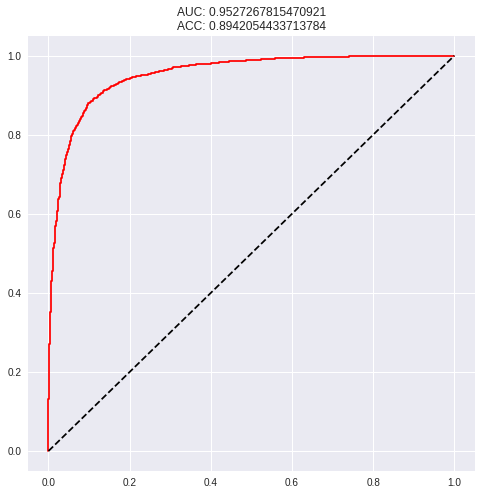

In [ ]:
plot_metrics(preds, y_test);